# Exploration and Import 

In [1]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=2626475 sha256=21a8a00f535a0c1e26dd6e0e1fe6806089e8feab58aaf60f1e136e44349bfee3
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast 
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from math import sqrt

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import accuracy, Dataset, SVD, Reader
from surprise.model_selection import cross_validate

import warnings; warnings.simplefilter('ignore')

In [3]:
dfMovies = pd.read_csv('https://raw.githubusercontent.com/ridhwanashir/sysRec_finalProject/main/ml-latest-small/movies.csv')
dfRatings = pd.read_csv('https://raw.githubusercontent.com/ridhwanashir/sysRec_finalProject/main/ml-latest-small/ratings.csv')
dfLinks = pd.read_csv('https://raw.githubusercontent.com/ridhwanashir/sysRec_finalProject/main/ml-latest-small/links.csv')
dfTags = pd.read_csv('https://raw.githubusercontent.com/ridhwanashir/sysRec_finalProject/main/ml-latest-small/tags.csv')

In [4]:
dfMerge = dfRatings.merge(dfMovies, how="left", on="movieId")
dfMerge.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


## Split Data

In [5]:
from sklearn.model_selection import train_test_split
indices = np.arange(len(dfMerge))
train_data, test_data, train_indices, test_indices = train_test_split(dfMerge, indices, test_size=0.25, random_state=42)

In [6]:
n_users = dfMerge.userId.unique().shape[0]
n_items = dfMerge.movieId.unique().shape[0]
print('jumlah user :', n_users, ' | jumlah movie :', n_items)

jumlah user : 610  | jumlah movie : 9724


In [7]:
print('jumlah Train :', len(train_data))
print('jumlah Test :', len(test_data))

jumlah Train : 75627
jumlah Test : 25209


In [8]:
# test_data[['userId','movieId','rating']].head()

In [9]:
# create train dataframe (removed test value)
train_data_matrix = train_data.pivot_table(index=["userId"], columns=["movieId"], values="rating", fill_value=0.)
df_train = dfMerge.pivot_table(index=["userId"], columns=["movieId"], values="rating", fill_value=0.)
for col in df_train.columns:
  df_train[col].values[:] = 0
for col in train_data_matrix.columns:
  df_train[col] = train_data_matrix[col]

In [10]:
df_train.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0


# Content-Based Filtering (tag and genre)

In [11]:
# preprocess movies data, strip title and genres
dfMovies_content = dfMovies[dfMovies['movieId'].isin(dfMerge['movieId'].unique())].copy() #filtered movie by train data
# dfMovies_content = dfMovies.copy()
dfMovies_content['year'] = dfMovies_content.title.str.extract('(\d\d\d\d)',expand=False)
dfMovies_content['title'] = dfMovies_content.title.str.replace('(\(\d\d\d\d\))', '')
dfMovies_content['title'] = dfMovies_content['title'].apply(lambda x: x.strip())

In [12]:
dfMovies_content.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [13]:
# extract the tag of each movie and merge into the main dataframe
dfMovies_content_tag = pd.merge(dfMovies_content, dfTags, on="movieId", how="left")
dfMovies_content_tag.fillna("", inplace =True)
dfMovies_content_tag['tag'] = dfMovies_content_tag['tag'].replace(np.nan, "")
dfMovies_content_tag = pd.DataFrame(dfMovies_content_tag.groupby("movieId")["tag"].apply(lambda x: "%s" % " ".join(x)))

# merge
dfMovies_content = pd.merge(dfMovies_content_tag, dfMovies_content,on = "movieId" ,how="left")
dfMovies_content.head()


,movieId,tag,title,genres,year
0,1,pixar pixar fun,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,fantasy magic board game Robin Williams game,Jumanji,Adventure|Children|Fantasy,1995
2,3,moldy old,Grumpier Old Men,Comedy|Romance,1995
3,4,,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,pregnancy remake,Father of the Bride Part II,Comedy,1995


In [14]:
dfMovies_content["metadata"] = dfMovies_content[["tag", "genres"]].apply(lambda x: "|".join(x),axis=1)
dfMovies_content = dfMovies_content[["movieId","title","metadata","year"]]
dfMovies_content['metadata'] = dfMovies_content['metadata'].str.lower()
dfMovies_content['metadata'] = dfMovies_content['metadata'].str.replace('|',' ')
dfMovies_content['metadata'] = dfMovies_content.metadata.str.split(' ')
# turn the list into a string
dfMovies_content['metadata'] = dfMovies_content['metadata'].apply(lambda x: " ".join(x))

In [15]:
dfMovies_content.head()

,movieId,title,metadata,year
0,1,Toy Story,pixar pixar fun adventure animation children c...,1995
1,2,Jumanji,fantasy magic board game robin williams game a...,1995
2,3,Grumpier Old Men,moldy old comedy romance,1995
3,4,Waiting to Exhale,comedy drama romance,1995
4,5,Father of the Bride Part II,pregnancy remake comedy,1995


### TFIDF

In [16]:
tfidf = TfidfVectorizer(stop_words='english')
dfMovies_content['metadata'] = dfMovies_content['metadata'].fillna('')

tfidf_matrix = tfidf.fit_transform(dfMovies_content['metadata'])
tfidf_matrix

<9724x1675 sparse matrix of type '<class 'numpy.float64'>'
	with 27803 stored elements in Compressed Sparse Row format>

In [17]:
# import linear_kernel from sklearn
from sklearn.metrics.pairwise import linear_kernel
### compute the cosine similarity using linear kernel
content_cosine = linear_kernel(tfidf_matrix, tfidf_matrix)

In [18]:
content_cosine.shape

(9724, 9724)

## Test Content Recommendation

In [19]:
movie_indices = pd.Series(dfMovies_content.index, index=dfMovies_content["movieId"])
def content_recommendation(movieId,n,cosine_sin=content_cosine):
    idx = movie_indices[movieId]
    sim_scores = enumerate(cosine_sin[idx])
    sim_scores = sorted(sim_scores, key=lambda x : x[1], reverse=True)
    # how many movies will recomend is set here
    sim_scores = sim_scores[1:n+1]            
    movies_movie_indices = [i[0] for i in sim_scores]
    movie_rec = dfMovies_content['movieId'].iloc[movies_movie_indices].reset_index()
    return movie_rec

In [20]:
dfMovies_content.sample()

,movieId,title,metadata,year
2051,2731,"400 Blows, The (Les quatre cents coups)",emotional gentle heartwarming lyrical reflecti...,1959


In [21]:
content_recommendation(1218,5).merge(train_data, on='movieId', how='left').groupby(['movieId'])

# Collaborative Filtering

In [22]:
# using data train here
data = Dataset.load_from_df(train_data[['userId', 'movieId', 'rating']], Reader())
svd = SVD()
# cross validate only using train data
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=4, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 4 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Mean    Std     
RMSE (testset)    0.8893  0.8855  0.8768  0.8819  0.8834  0.0046  
MAE (testset)     0.6863  0.6826  0.6773  0.6792  0.6814  0.0034  
Fit time          1.51    2.73    3.28    2.43    2.49    0.64    
Test time         0.36    0.35    0.55    0.27    0.38    0.10    


{'test_rmse': array([0.88931621, 0.88547357, 0.8768366 , 0.88186194]),
 'test_mae': array([0.68634494, 0.68255883, 0.67733843, 0.67917979]),
 'fit_time': (1.512092113494873,
  2.7341227531433105,
  3.276318311691284,
  2.4332497119903564),
 'test_time': (0.35586977005004883,
  0.3539388179779053,
  0.5524406433105469,
  0.2668118476867676)}

In [23]:
trainset = data.build_full_trainset()
svd.fit(trainset)

## Test Collaborative Recommendation

In [24]:
# user rating
dfRatings[dfRatings['userId']==1].sample(5)

,userId,movieId,rating,timestamp
85,1,1270,5.0,964983705
104,1,1620,4.0,964983056
80,1,1226,5.0,964983618
165,1,2542,5.0,964981265
90,1,1298,5.0,964984086


In [25]:
svd.predict(1,2529)

Prediction(uid=1, iid=2529, r_ui=None, est=4.667196568122911, details={'was_impossible': False})

In [26]:
svd.predict(1,2105)

Prediction(uid=1, iid=2105, r_ui=None, est=3.9576526376540992, details={'was_impossible': False})

# Hybrid Filtering

Using svd model from collaborative and content_cosine from content-based filtering

In [27]:
dfMovies_content.head()

,movieId,title,metadata,year
0,1,Toy Story,pixar pixar fun adventure animation children c...,1995
1,2,Jumanji,fantasy magic board game robin williams game a...,1995
2,3,Grumpier Old Men,moldy old comedy romance,1995
3,4,Waiting to Exhale,comedy drama romance,1995
4,5,Father of the Bride Part II,pregnancy remake comedy,1995


In [28]:
movie_indices = pd.Series(dfMovies_content.index, index=dfMovies_content["movieId"])
def hybrid_recommendation(userId, movieId, n, cosine_sin=content_cosine):
    # content
    idx = movie_indices[movieId]
    sim_scores = enumerate(cosine_sin[idx])
    sim_scores = sorted(sim_scores, key=lambda x : x[1], reverse=True)
    # how many movies will recomend is set here
    sim_scores = sim_scores[1:51]            
    movies_movie_indices = [i[0] for i in sim_scores]

    movies = dfMovies_content.iloc[movies_movie_indices][['movieId','title', 'metadata', 'year']]
    movies['est'] = movies['movieId'].apply(lambda x: svd.predict(userId, x).est)
    movies = movies.sort_values('est', ascending=False)

    return movies[:n]

### Testing Hybrid

In [29]:
test_data[test_data['userId'] == 2]

,userId,movieId,rating,timestamp,title,genres
250,2,89774,5.0,1445715189,Warrior (2011),Drama
253,2,99114,3.5,1445714874,Django Unchained (2012),Action|Drama|Western
239,2,48516,4.0,1445715064,"Departed, The (2006)",Crime|Drama|Thriller
256,2,112552,4.0,1445714882,Whiplash (2014),Drama


In [30]:
hybrid_recommendation(2, 48516, 1)

,movieId,title,metadata,year,est
510,593,"Silence of the Lambs, The",hannibal lector disturbing drama gothic psycho...,1991,4.316916


In [31]:
hybrid_recommendation(2, 48516, 5)['est'].mean()

4.262679225224528

## Predicting Test Data

In [32]:
actual_data = test_data['rating'].values

In [33]:
predicted_data = []
for i,item in test_data.iterrows():
  predicted_data.append(hybrid_recommendation(item['userId'], item['movieId'],5)['est'].mean())

# Evaluation

In [34]:
def evaluation(prediction, truth):
  return sqrt(mean_squared_error(prediction, truth)), mean_squared_error(prediction, truth), mean_absolute_percentage_error(prediction, truth), mean_absolute_error(prediction, truth)

In [35]:
  # evaluasi hybrid
  rmse, mse, mape, mae = evaluation(predicted_data, actual_data)
  print('\nEvaluasi performa ')
  print('RMSE score : ',rmse)
  print('MSE score : ',mse)
  print('MAPE score : ',mape)
  print('MAE score : ',mae)


Evaluasi performa 
RMSE score :  0.9871590129437523
MSE score :  0.9744829168360833
MAPE score :  0.19939076325592034
MAE score :  0.7417878372876817


Dibandingkan dengan classic CBF/CF

In [36]:
# content-based
predicted_data_cbf = []
for i,item in test_data.iterrows():
  predicted_data_cbf.append(content_recommendation(item['movieId'],5).merge(train_data, on='movieId', how='left').groupby(['movieId']).mean()['rating'].mean())
rmse, mse, mape, mae = evaluation(predicted_data_cbf, actual_data)
print('\nEvaluasi performa ')
print('RMSE score : ',rmse)
print('MSE score : ',mse)
print('MAPE score : ',mape)
print('MAE score : ',mae)


Evaluasi performa 
RMSE score :  1.0552923500228126
MSE score :  1.1136419440166705
MAPE score :  0.26282056627068473
MAE score :  0.8438538289409023


In [37]:
# collaborative
predicted_data_cf = []
for i,item in test_data.iterrows():
  predicted_data_cf.append(svd.predict(item['userId'], item['movieId']).est)
rmse, mse, mape, mae = evaluation(predicted_data_cf, actual_data)
print('\nEvaluasi performa ')
print('RMSE score : ',rmse)
print('MSE score : ',mse)
print('MAPE score : ',mape)
print('MAE score : ',mae)


Evaluasi performa 
RMSE score :  0.8804448692677815
MSE score :  0.7751831678199609
MAPE score :  0.20217227815433952
MAE score :  0.6742021244292865


# Visualisasi Hasil

## MSE

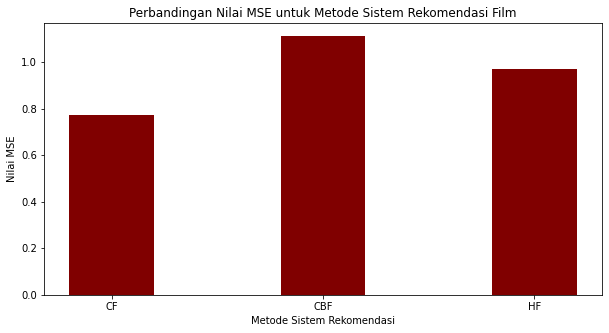

In [38]:
import numpy as np
import matplotlib.pyplot as plt


# creating the dataset
data = {'CF':0.772, 'CBF':1.113, 'HF':0.973}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='maroon',
		width = 0.4)

plt.xlabel("Metode Sistem Rekomendasi")
plt.ylabel("Nilai MSE")
plt.title("Perbandingan Nilai MSE untuk Metode Sistem Rekomendasi Film")
plt.show()


## RMSE

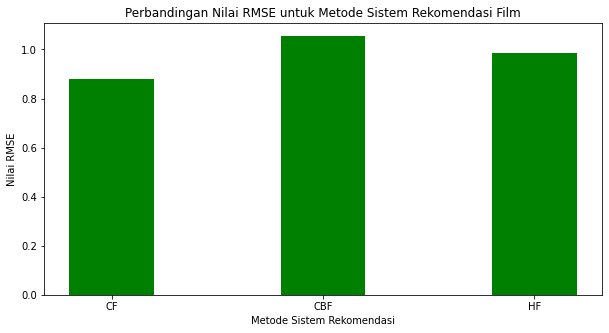

In [39]:
import numpy as np
import matplotlib.pyplot as plt


# creating the dataset
data = {'CF':0.879, 'CBF':1.055, 'HF':0.987}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='green',
		width = 0.4)

plt.xlabel("Metode Sistem Rekomendasi")
plt.ylabel("Nilai RMSE")
plt.title("Perbandingan Nilai RMSE untuk Metode Sistem Rekomendasi Film")
plt.show()

## MAE

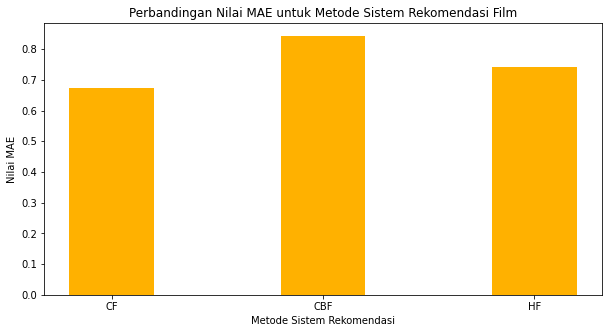

In [40]:
import numpy as np
import matplotlib.pyplot as plt


# creating the dataset
data = {'CF':0.673, 'CBF':0.843, 'HF':0.742}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='#FFB100',
		width = 0.4)

plt.xlabel("Metode Sistem Rekomendasi")
plt.ylabel("Nilai MAE")
plt.title("Perbandingan Nilai MAE untuk Metode Sistem Rekomendasi Film")
plt.show()

## MAPE

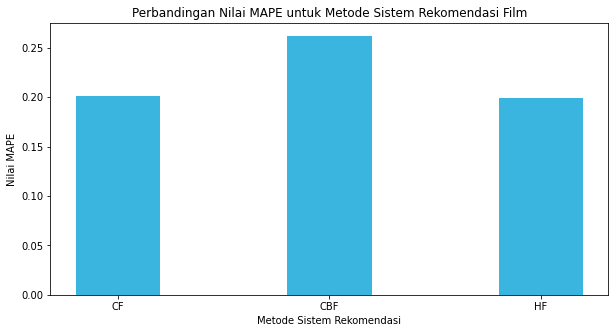

In [41]:
import numpy as np
import matplotlib.pyplot as plt


# creating the dataset
data = {'CF':0.201, 'CBF':0.262, 'HF':0.199}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='#39B5E0',
		width = 0.4)

plt.xlabel("Metode Sistem Rekomendasi")
plt.ylabel("Nilai MAPE")
plt.title("Perbandingan Nilai MAPE untuk Metode Sistem Rekomendasi Film")
plt.show()